In [1]:
from f_train import *
from f_drosophila_infer import *
from f_data_prep import *
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit

In [2]:
data_all = np.loadtxt('../data_complete.txt')
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

def make_quad(X):
    quad = np.zeros((int(X.shape[0]), int(X.shape[1] + (X.shape[1]*(X.shape[1]-1))/2)))
    quad[:, :X.shape[1]] = np.copy(X)
    col = X.shape[1]
    for i in range(X.shape[1]-1):
        for j in range(i+1, X.shape[1]):
            quad[:,col] = (X[:,i]*X[:,j])
            col += 1
    return quad

with open('./pickles/validation_cells.pkl', 'rb') as f:
    cells_v = pickle.load(f)

In [3]:
def skl_cv_quad_cellselect(X, y, n=547):
    quad = np.zeros((int(X.shape[0]), int(X.shape[1] + (X.shape[1]*(X.shape[1]-1))/2)))
    quad[:, :X.shape[1]] = np.copy(X)
    col = 99
    for i in range(X.shape[1]-1):
        for j in range(i+1, X.shape[1]):
            quad[:,col] = (X[:,i]*X[:,j])
            col += 1
    
    val = np.hstack([cells_v+(6078*i) for i in range(5)])
    cells_tt = np.delete(range(6078), cells_v)
    
    X_v = X[val]
    quad_v = quad[val]
    y_v = y[val]
    
    ya = X_v + y_v
    
    w_list = []
    bias_list = []
    ferror_list = []
    error1_list = []
    
    for i in range(1):
        cells_tr = np.random.choice(cells_tt, size=n, replace=False)
#         print(cells_tr[:10])
        tr_ind = np.hstack([cells_tr+(6078*j) for j in range(5)])
    #         print(len(tr_ind))
        quad_tr = quad[tr_ind]
        y_tr = y[tr_ind]

        regr = linear_model.LinearRegression()
        regr.fit(quad_tr, y_tr)
        w = regr.coef_
        w_list.append(w.T)

        bias = regr.intercept_
        bias_list.append(bias)

    #         print(w.T.shape)
    #         print(bias.shape)

        yp = X_v + bias + quad_v.dot(w.T)
        yp[yp<0] = 0

        ferror = (np.sum(np.abs(yp - ya)**2, axis=0)/np.sum(np.abs(ya)**2, axis=0))**(1/2)
        ferror_list.append(ferror)
        error1 = np.abs(yp - ya)
        error1_list.append(error1)
    
    dic = {
        'ferror': ferror_list,
        'error': error1_list,
        'w': w_list,
        'bias': bias_list
    }
    return dic

In [4]:
# ratio = np.array([int(5470*i) for i in [0.2,0.22,0.24,0.26,0.28,0.3,0.33,0.36,0.4,0.45,0.5,0.55,0.6]])
# res = []
# for i in ratio:
#     result = skl_cv_quad_cellselect(all_init, all_diff, n=i)
#     res.append(result)
# with open('./pickles/titration_skl.pkl', 'wb') as f:
#     pickle.dump(res, f)

In [5]:
with open('./pickles/skl_(99,99)_tv.pkl', 'rb') as f:
    skl = pickle.load(f)
w_skl = skl['w'].T

with open('./pickles/LAD_(99,99)_ttv.pkl', 'rb') as f:
    LAD = pickle.load(f)
w_LAD = LAD['w']

In [6]:
with open('./pickles/titration_skl.pkl', 'rb') as f:
    res_skl = pickle.load(f)

In [7]:
ratio = [20,22,24,26,28,30,33,36,40,45,50,55,60]
diff_LAD = []
for r in ratio:
    w = np.zeros((4950,99))
    bias = np.zeros(99)
    for k in range(990):
        i = int(k/10)
        with open('./pickles/titrate_%s/res_%s.pkl' % (r,k), 'rb') as f:
            res = pickle.load(f)
        w[:, i:(i+1)] += res[0]
    w = w/10
    diff_LAD.append(np.linalg.norm(w_LAD - w))

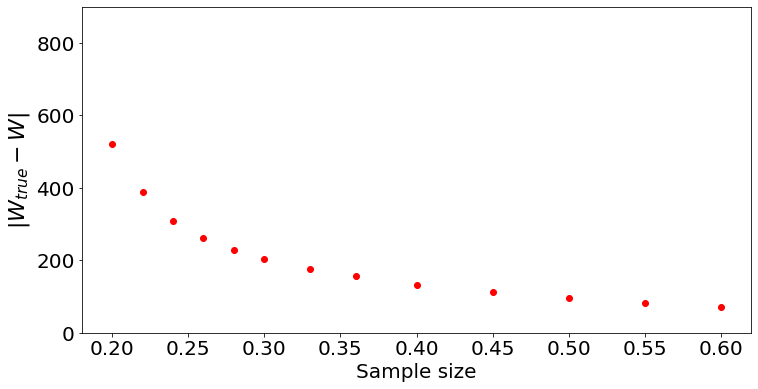

In [8]:
matplotlib.rcParams.update({'font.size':20})

ratio = [0.2,0.22,0.24,0.26,0.28,0.3,0.33,0.36,0.4,0.45,0.5,0.55,0.6]

with open('./pickles/titration_skl.pkl', 'rb') as f:
    res_skl = pickle.load(f)
plt.figure(figsize=(12,6))
for i in range(len(ratio)):
#     diff =[np.linalg.norm(w_skl-res_skl[i]['w'][j]) for j in range(1)]
#     plt.plot(ratio[i], diff, 'ko', label='LS')
#     plt.xticks([0.2,0.3,0.4,0.5,0.6],['20%','30%','40%','50%','60%'])
    plt.ylim(0,900)
    plt.ylabel('$|W_{true} - W|$', fontsize=22)
    plt.xlabel('Sample size')

for i in range(len(diff_LAD)):
    plt.plot(ratio[i], diff_LAD[i], 'ro', label='LAD')

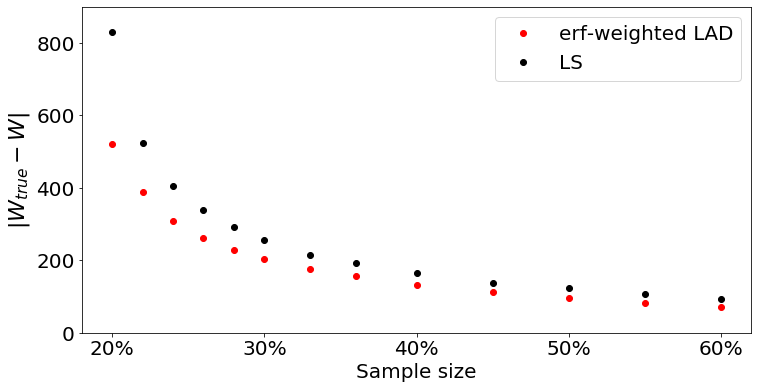

In [9]:
matplotlib.rcParams.update({'font.size':20})

ratio = [0.2,0.22,0.24,0.26,0.28,0.3,0.33,0.36,0.4,0.45,0.5,0.55,0.6]

with open('./pickles/titration_skl.pkl', 'rb') as f:
    res_skl = pickle.load(f)
plt.figure(figsize=(12,6))
plt.plot(ratio, diff_LAD, 'ro', label='erf-weighted LAD')
diff_skl =[np.linalg.norm(w_skl-res_skl[i]['w'][0]) for i in range(13)]
plt.plot(ratio, diff_skl, 'ko', label='LS')
plt.xticks([0.2,0.3,0.4,0.5,0.6],['20%','30%','40%','50%','60%'])
plt.xlim(0.18,0.62)
plt.ylim(0,900)
plt.ylabel('$|W_{true} - W|$', fontsize=22)
plt.xlabel('Sample size')
plt.legend()
plt.savefig('titrated.pdf', bbox_inches='tight')

In [10]:
data_all = np.loadtxt('../data_complete.txt')
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

def make_quad(X):
    quad = np.zeros((int(X.shape[0]), int(X.shape[1] + (X.shape[1]*(X.shape[1]-1))/2)))
    quad[:, :X.shape[1]] = np.copy(X)
    col = X.shape[1]
    for i in range(X.shape[1]-1):
        for j in range(i+1, X.shape[1]):
            quad[:,col] = (X[:,i]*X[:,j])
            col += 1
    return quad

with open('./pickles/validation_cells.pkl', 'rb') as f:
    cells_v = pickle.load(f)

val = np.hstack([cells_v+(6078*i) for i in range(5)])

X_v = all_init[val]
quad_v = make_quad(X_v)
y_v = all_diff[val]

w = np.zeros((4950,99))
bias = np.zeros(99)
for k in range(990):
    i = int(k/10)
    with open('./pickles/titrate_20/res_%s.pkl' % (k), 'rb') as f:
        res = pickle.load(f)
    w[:,i:(i+1)] += res[0]
    bias[i] += res[1]
w = w/10
bias = bias/10

yp = X_v + bias + quad_v.dot(w)
yp[yp<0] = 0
ya = X_v + y_v

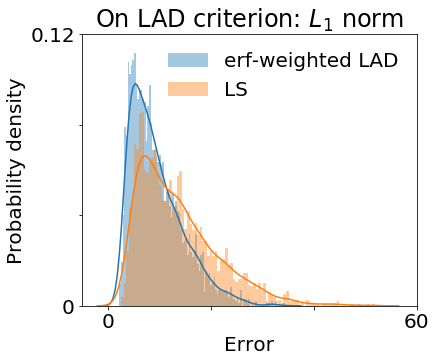

MannwhitneyuResult(statistic=3067594.0, pvalue=2.4268102371774094e-114)


In [11]:
matplotlib.rcParams.update({'font.size':20})
matplotlib.rcParams['legend.frameon'] = False

error_lad = np.abs(yp-ya)

with open('./pickles/titration_skl.pkl', 'rb') as f:
    res_skl = pickle.load(f)
    
error_skl = res_skl[0]['error'][0]

plt.figure(figsize=(6,5))
sns.distplot(np.sum(error_lad, axis=1), bins=100, label='erf-weighted LAD')
sns.distplot(np.sum(error_skl, axis=1), bins=100, label='LS')
plt.xlim(-5,60)
plt.xticks([0,20,40,60],['0','','','60'])
plt.ylim(0,0.12)
plt.yticks([0,0.04,0.08,0.12],['0','','','0.12'])
plt.xlabel('Error')
plt.ylabel('Probability density')
plt.legend()
plt.title('On LAD criterion: $L_{1}$ norm')
plt.savefig('L1_small.pdf', bbox_inches='tight')
plt.show()

print(stats.mannwhitneyu(np.sum(error_lad, axis=1), np.sum(error_skl, axis=1), alternative='less'))

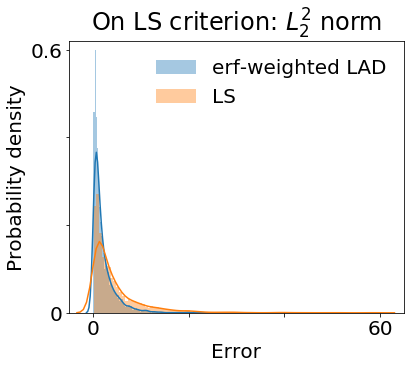

MannwhitneyuResult(statistic=3074408.0, pvalue=2.3240698621545703e-113)


In [12]:
plt.figure(figsize=(6,5))
sns.distplot(np.sum(error_lad**2, axis=1), bins=100, label='erf-weighted LAD')
sns.distplot(np.sum(error_skl**2, axis=1), bins=100, label='LS')
plt.xlim(-5,65)
plt.ylim(0,0.62)
plt.xticks([0,20,40,60],['0','','','60'])
plt.yticks([0,0.2,0.4,0.6],['0','','','0.6'])
plt.xlabel('Error')
plt.ylabel('Probability density')
plt.legend()
plt.title('On LS criterion: $L_{2}^{2}$ norm')
plt.savefig('L2_small.pdf', bbox_inches='tight')
plt.show()

print(stats.mannwhitneyu(np.sum(error_lad**2, axis=1), np.sum(error_skl**2, axis=1), alternative='less'))